In [53]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Binary Classification

In binary classification, just as in the previous section, we're also trying to make a binary decision. A key difference is that instead of using the language of hypothesis testing, we use the language of machine learning and classification: we have data points that we're trying to classify as belonging to one of two groups, which (without loss of generality) we'll call class 0 and class 1.

In hypothesis testing, we made our decision using $p$-values, which captured the probability (for each test), given the data, that our data were observed under some null hypothesis. In binary classification, we're interested in the probability, given the data, that our data were observed under class 0 or under class 1. Most classification algorithms will give us some arbitrary number. These numbers are often, but not always, between 0 and 1, in which case we can interpret them as the probability of belonging to class 1. We typically apply a threshold to that number to obtain a binary decision. 

For example, logistic regression produces probabilities: for a particular datum, a logistic regression classifier might predict that it has a 0.7 probability of belonging to class 1. We apply some threshold (often, but not always 0.5): if our value is above the threshold (as in this case), we make a decision of 1; otherwise, we make a decision of 0.

While the mechanics of obtaining a decision are different for binary classification, the big ideas we've learned in the last few section remain just as relevant: in particular, we can think about the tradeoffs involved by understanding the row-wise and columnn-wise error rates. In binary classification, we visualize and analyze these error rates primarily through two visualizations: a receiver operating characteristic (ROC) curve, and a precision-recall curve.

## ROC Curves: Trading off Row-Wise Rates

ROC curves help us visualize the tradeoff between different **row-wise rates**. Let's make things concrete with an example. Suppose a manufacturing company trains a classifier that uses computer vision (e.g., a vision transformer) to predict whether each product coming off its assembly line is defective (1) or not (0). They obtain the following results on a held-out test set:

In [35]:
defects = pd.read_csv('manufacturing.csv')
defects.head()

,is_defective,predicted_prob
0,False,0.284021
1,False,0.277903
2,True,0.653581
3,False,0.090320
4,False,0.173007


In [36]:
def formatted_confusion_matrix(y_true, y_pred):
    return pd.DataFrame(
        data=confusion_matrix(y_true, y_pred),
        index=['R=0', 'R=1'],
        columns=['D=0', 'D=1']
    )

In [47]:
formatted_confusion_matrix(defects['is_defective'], defects['predicted_prob'] > 0.5)

,D=0,D=1
R=0,641,167
R=1,36,156


In [40]:
formatted_confusion_matrix(defects['is_defective'], defects['predicted_prob'] > 0.2)

,D=0,D=1
R=0,364,444
R=1,2,190


Just as before, we can see the same tradeoff between the row-wise rates: as our TPR increases (i.e., we are better at catching defective products), our FPR also increases (i.e., we get worse with non-defective products). The examples above show two points on that tradeoff, but there exists one such point for each different possible threshold value. Instead of computing and manually reviewing the confusion matrix for each threshold, we can instead visualize the TPR and FPR associated with each possible one by using the `roc_curve` function in `scikit-learn`:

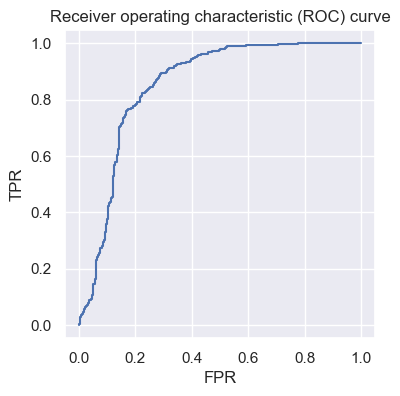

In [34]:
fprs, tprs, thresholds_roc = roc_curve(defects['is_defective'], defects['predicted_prob'])

f, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(fprs, tprs)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.axis('equal')
ax.set_title('Receiver operating characteristic (ROC) curve');

Each point on this graph represents one threshold. For example, the point at around (0.2, 0.8) tells us that if we choose that particular threshold value, we'll achieve a false positive rate of 0.2 and a true positive rate of 0.8. 

What if that FPR was unacceptably high? We could instead choose a threshold corresponding to the point at around (0.1, 0.4). This tells us that if we want a smaller FPR of 0.1, we have to accept a much lower TPR of 0.1.

This provides us a way of clearly visualizing the tradeoffs involved, at least as far as the row-wise rates are concerned.

**Exercise**: write code to find the threshold value that gives us an FPR as close as possible to 0.2. *Hint: use the `thresholds_roc` array.*

### Precision-Recall Curves and Column-Wise Rates

We saw in previous sections that the row-wise rates alone can't tell us the whole story! We saw that in cases where the prevalence is low, even if we have relatively high row-wise rates, our column-wise rates can be quite low. In this example, a threshold of 0.5 leads to a TPR and TNR close to 0.8 (i.e., our algorithm is about $80\%$ accurate for defective products and about $80\%$ accurate for non-defective products), but a prediction of "defective" will be wrong more than half the time!

In [52]:
display(formatted_confusion_matrix(defects['is_defective'], defects['predicted_prob'] > 0.5))
print(156/(36+156), 641/(167+641))

,D=0,D=1
R=0,641,167
R=1,36,156


0.8125 0.7933168316831684


Just as the ROC curve plots the true positive rate against the false positive rate, a precision-recall curve plots the precision against the recall.

Remember from before that the **precision** is the complement of the FDP: in other words, it describes how well we do when we make a decision of $D=1$, or in this case, when the classifier flags a product as defective. The **recall** is just another term for the true positive rate (which we've also referred to as the power and sensitivity). Plotting these two helps us understand the tradeoffs between row-wise and column-wise rates. Let's see what it looks like for the example above:

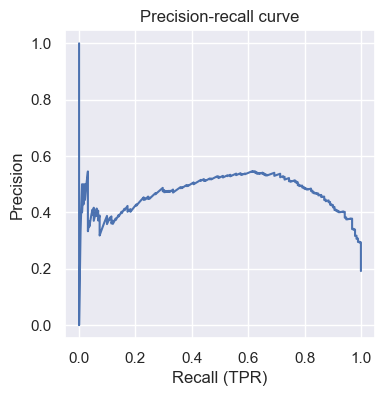

In [58]:
precisions, recalls, thresholds_pr = precision_recall_curve(defects['is_defective'], defects['predicted_prob'])

f, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(recalls, precisions)
ax.set_xlabel('Recall (TPR)')
ax.set_ylabel('Precision')
ax.axis('equal')
ax.set_title('Precision-recall curve');

We can see that this tells us a complementary story. We can see that the left part of the curve is very noisy, and in the center, as recall improves, precision improves up to about 0.55 until it starts dropping off quickly for much higher values of the recall. What does this mean?

**Exercise**: explain why the left part of the curve looks so noisy. *Hint: consider what kind of threshold will lead to very low recall, and then explain how that kind of threshold affects the denominator in our precision calculation.*

**Exercise**: explain why the precision increases with recall for a while before decreasing for recall values higher than about 0.6.